In [1]:
# Code is heavily inspired from:
# http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [2]:
# Implementing a simple 3 layer neural network from scratch

In [3]:
# importing libraries
import numpy as np
import sklearn.datasets as datasets
from sklearn.linear_model import LogisticRegressionCV
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

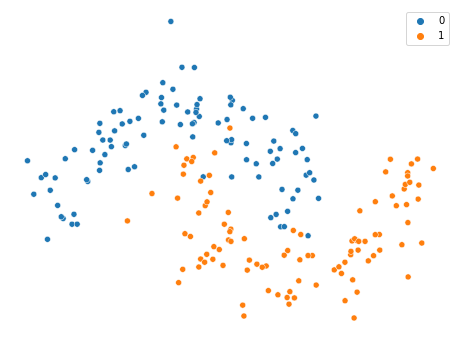

In [4]:
# generating a dataset and plotting it
np.random.seed(2021)

X, y = datasets.make_moons(200, noise = 0.20)

plt.figure(figsize = (8,6))
sns.scatterplot(X[:,0], X[:,1], hue = y)
plt.axis('off')
plt.show()

In [5]:
# helper function to plot a decision boundary
def plot_decision_boundary(pred_func):
    # setting min-max values with some padding
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    h = 0.01
    # generating a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # predicting the function value for the whole grid
    z = pred_func(np.c_[xx.ravel(),yy.ravel()])
    z = z.reshape(xx.shape)
    
    # plot the contour and training examples
    #plt.figure(figsize = (8,6))
    plt.contourf(xx, yy, z, cmap = plt.cm.coolwarm)
    sns.scatterplot(X[:,0], X[:,1], hue = y, legend = False)
    #plt.scatter(X[:,0], X[:,1], c = y)
    plt.axis('off')

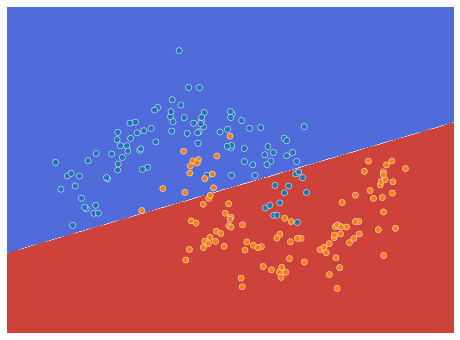

In [6]:
# lets see how a machine learning classifier works on the data before moving
# on to a deep learning model

clf = LogisticRegressionCV()
clf.fit(X, y)

# plotting decision boundary
plot_decision_boundary(lambda x: clf.predict(x))

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight ine, but its unable to capture the "moon shape" of our data

### lets train a neural network and see how it performs on our data

<b>Neural network architecture design:</b>

Input layer -> Hidden layer -> Output layer

Input layer dimensionality is 2 wrt our input.

<b>Activation function in hidden layer:</b><br>
Possible choices for activation functions are sigmoid, relu and tanh.
we will go with sigmoid for the time being because the derivative of sigmoid can be calculated with the original function value.
For example: derivative of sigmoid is sigmoid*(1-sigmoid)

<b>output layer:</b><br>
Because we want our neural network to output probabilities, the activation function for output layer will be softmax, which is to convert raw scores to probabilities.
    
<b>How our network makes predictions:</b><br>
X is 2 dim input, then we calculate our prediction ybar as:<br>
<i>z<sub>1</sub> = x * W<sub>1</sub> + b<sub>1</sub></i><br>
<i>a<sub>1</sub> = Sigmoid(z<sub>1</sub>)</i><br>
<i>z<sub>2</sub> = a<sub>1</sub> * W<sub>2</sub> + b<sub>2</sub></i><br>
<i>a<sub>2</sub> = ybar = Softmax(z<sub>2</sub>)</i>

<b>Learning the parameters</b>
Learning the parameters means finding parameters (<i>W<sub>1</sub></i>, <i>b<sub>1</sub></i>, <i>W<sub>2</sub></i>, <i>b<sub>2</sub></i>) that minimize the error on our training loss. we will use <a href = "https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression">cross entropy loss</a>. We will use <a href = "https://cs231n.github.io/optimization-1/">gradient descent</a> to find the minimum value for our parameters.

<b>Applying the backpropagation formula we find the following:</b><br>
<i>del<sub>3</sub> = a<sub>2</sub> - y</i><br>
<i>del<sub>2</sub> = del<sub>3</sub> * W<sub>2</sub><sup>T</sup> * Sigmoid(z<sub>1</sub>) * (1 - Sigmoid(z<sub>1</sub>))</i><br>
<i>del<b>Loss</b> / del<b>b<sub>2</sub></b> = del<sub>3</sub></i><br>
<i>del<b>Loss</b> / del<b>W<sub>2</sub></b> = a<sub>1</sub><sup>T</sup> * del<sub>3</sub></i><br>
<i>del<b>Loss</b> / del<b>b<sub>1</sub></b> = del<sub>2</sub></i><br>
<i>del<b>Loss</b> / del<b>W<sub>1</sub></b> = x<sup>T</sup> * del<sub>2</sub></i><br>

for more information on how to calculate the above derivatives, please go through the below resources:
- <a href = "https://deepnotes.io/softmax-crossentropy">How to calculate derivative of Cross Entropy Loss when used with Softmax?</a>
- <a href = "http://colah.github.io/posts/2015-08-Backprop/">Calculus on Computational Graphs: Backpropagation</a>
- <a href = "https://cs231n.github.io/optimization-2/">CS231n CNN for visual recognition</a>
- <a href = "https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b">Yes you should understand backprop by Andrej Karpathy</a>

### Implementation

Now we are ready for implementation, we define some useful variables and parametes for gradient descent

In [7]:
num_examples = len(X) # training set size
input_dim = 2 # input layer dimensionality
output_dim = 2 # output layer dimensionality

learning_rate = 0.01 # learning rate for gradient descent
reg_param = 0.01 # regularization parameter

Implementing loss function as defined above to evaluate how well our model is doing:

In [8]:
# helper functions to calculate sigmoid and softmax function values
def sigmoid(z):
    s = 1 / (1 + np.exp((-1 * z)))
    return s

def softmax(z):
    z_exp = np.exp(z)
    return z_exp / np.sum(z_exp, axis = 1, keepdims = True)

In [9]:
def calculate_loss(model):
    W1, b1, W2, b2 = model["W1"], model["b1"], model["W2"], model["b2"]
    
    # forward propagation to calculate our predictions
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    # calculating the loss
    # a2[range(num_examples), y] = a2[range(0, 200), y]
    # a2 is of shape (200, 2), y is of shape(200,)
    # is used to access the value using i,j positions from a2 resulting in a shape of (200,)
    correct_logprobs = -np.log(a2[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    
    # Adding regularization to loss 
    data_loss += reg_param/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return (1./num_examples) * data_loss

In [10]:
# Helper function to predict an output (0 or 1)
def predict(model, X):
    W1, b1, W2, b2 = model["W1"], model["b1"], model["W2"], model["b2"]
    
    # forward propagation to calculate our predictions
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    
    return np.argmax(a2, axis = 1)

Final function to train our Neural Network. it implements batch gradient descent using backpropagation derivatives we found above.

In [11]:
loss_history = []
def build_model(hidden_dim = 3, num_pass = 2000, print_loss = False, print_iteration = 10):
    # Initialize the parameters to random values, we are going to learn on these parameters
    np.random.seed(2021)
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))
    
    # creating a dictionary which stores the state information of the parameters.
    model = {}
    
    # gradient descent for each batch
    for i in range(0, num_pass):
        
        # forward propagration
        z1 = np.dot(X, W1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2) + b2
        a2 = softmax(z2)
        
        # backward propagation
        del3 = a2
        del3[range(num_examples), y] -= 1
        
        del2 = np.dot(del3, W2.T) * (sigmoid(z1) * (1 - sigmoid(z1)))
        
        delW2 = np.dot(a1.T, del3)
        delb2 = np.sum(del3, axis = 0, keepdims = True)
        
        delW1 = np.dot(X.T, del2)
        delb1 = np.sum(del2, axis = 0)
        
        # adding regulariation terms:
        delW2 += reg_param * W2
        delW1 += reg_param * W1
        
        # gradient descent parameter update
        W1 += -1 * learning_rate * delW1
        b1 += -1 * learning_rate * delb1
        W2 += -1 * learning_rate * delW2
        b2 += -1 * learning_rate * delb2
        
        # Assigning new parameters to the model
        model = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2}
        
        # plotting boundary after every iteration
        #plot_decision_boundary(lambda x: predict(model, x))
        #plt.title("{}".format(i))
        #plt.savefig("./neural_training/Iteration_{}.png".format(i))
        
        # optionally print loss
        # this is an expensive operation as it uses the whole dataset, so we dont want to do this too often
        if print_loss and (i+1) % print_iteration == 0:
            print("loss after iteration {} : {}".format(i+1, calculate_loss(model)))
            loss_history.append(calculate_loss(model))
            
            # saving image with decision boundary after every print_iteration parameter
            plot_decision_boundary(lambda x: predict(model, x))
            plt.title("{}".format(i))
            plt.savefig("./neural_training/Iteration_{}.png".format(i))
    return model

loss after iteration 20 : 0.38173464569389276
loss after iteration 40 : 0.32260950443821734
loss after iteration 60 : 0.31592314072112276
loss after iteration 80 : 0.31474448208344286
loss after iteration 100 : 0.31419706046573587
loss after iteration 120 : 0.31376343144566754
loss after iteration 140 : 0.31338111428420184
loss after iteration 160 : 0.31303845540332603
loss after iteration 180 : 0.3127299498729189
loss after iteration 200 : 0.31245123719730744
loss after iteration 220 : 0.3121985225278358
loss after iteration 240 : 0.31196847542921874
loss after iteration 260 : 0.3117581785330912
loss after iteration 280 : 0.31156508341569167
loss after iteration 300 : 0.31138696979751007
loss after iteration 320 : 0.31122190757226925
loss after iteration 340 : 0.31106822155149305
loss after iteration 360 : 0.31092445894882803
loss after iteration 380 : 0.3107893596707517
loss after iteration 400 : 0.3106618294508664
loss after iteration 420 : 0.31054091579998644
loss after iteration 4

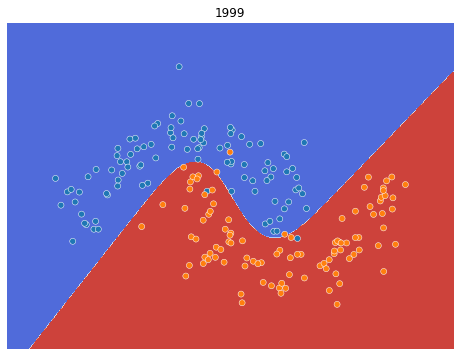

In [12]:
# build a model with 3-dim hidden layer
model = build_model(3, num_pass = 2000, print_loss = True, print_iteration = 20)

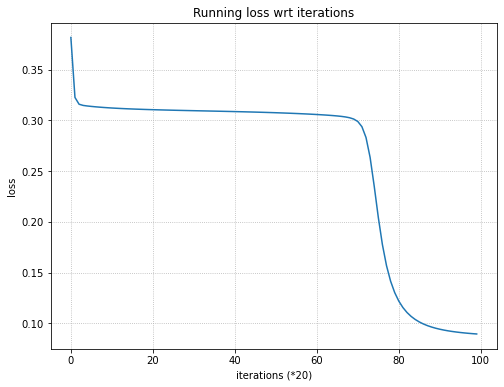

In [13]:
# plotting loss to see how our gradient descent is working
plt.plot(loss_history)
plt.ylabel("loss")
plt.xlabel("iterations (*20)")
plt.title("Running loss wrt iterations")
plt.grid(linestyle = ":")
plt.show()

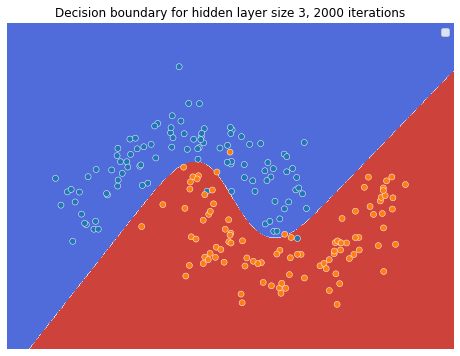

In [14]:
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision boundary for hidden layer size 3, 2000 iterations")
plt.legend({})
plt.axis('off')
plt.show()

### Varying the hidden layer size

In [ ]:
plt.figure(figsize = (16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 35, 50]

for i, hidden_dim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    model = build_model(hidden_dim, num_pass = 10000)
    plot_decision_boundary(lambda x: predict(model, x))
    plt.title("hidden layer size {}".format(hidden_dim))
plt.show()

We can see that while a hidden layer of low dimensionality captures the general trend of our data, higher dimensionalities tend to overfit the data. They are memorizing the data as opposed to fitting to general shape.